# Building a recommender system with embedding

In [1]:
%reload_ext jupyter_black

In [2]:
# Cleaning up the datasets
from typing import Iterable
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, Any
import sklearn.model_selection


def load_min_data(filename: str | Iterable):
    dfs = []
    if isinstance(filename, str):
        filename = [filename]
    for fn in filename:
        df = pd.read_csv(fn)
        # All min-datasets have an index column which has to be dropped:
        dfs.append(df.drop(df.columns[0], axis=1))
    return dfs


def clean_customer_data(df):
    # df = df.drop("FN", axis=1) # I they're not exactly equal
    df.loc[
        ~df["fashion_news_frequency"].isin(["Regularly", "Monthly"]),
        "fashion_news_frequency",
    ] = "None"
    return df

Due to the size of the data, it's important to generate negative labels in an efficient way. The function `pandas.DataFrame.sample()` takes almost five seconds for each sample, which is called at least `n_negative` times, we instead transform the dataframe to a NumPy array. Below is a comparison to highlight the importance of working with simpler objects.

In [3]:
def time_pd_vs_np(n_negative, df) -> Tuple[float, float]:
    """Compute time it takes to sample n_negative negative transactions

    Args:
        n_negative (int): Number of negative samples
        df (pd.DataFrame): Dataframe to sample from, requires columns 'customer_id' and 'article_id'

    Returns:
        Tuple[float, float]: Time taken using Pandas objects (first value) and NumPy objects (second value)
    """
    import time

    start_pd = time.time()
    num_written = 0
    tmpStr = "customer_id,article_id\n"
    while num_written < n_negative:
        # Choose random customer and article
        selection = np.array(
            [
                df["customer_id"].sample().values,
                df["article_id"].sample().values,
            ]
        ).flatten()
        if not (
            (df["customer_id"] == selection[0]) & (df["article_id"] == selection[1])
        ).any():
            tmpStr += f"{selection[0]}, {selection[1]}\n"
            num_written += 1
    with open("tmp.csv", "w") as f:
        f.write(tmpStr)
    df_negative = pd.read_csv("tmp.csv")
    os.remove("tmp.csv")
    time_pd = time.time() - start_pd

    # Numpy method
    start_np = time.time()
    df_np = df[["customer_id", "article_id"]].to_numpy()
    neg_np = np.empty((n_negative, df_np.shape[1]), dtype="<U64")
    for i in range(n_negative):
        legit = False
        while not legit:
            sample = [np.random.choice(df_np[:, col]) for col in range(df_np.shape[1])]
            legit = not ((df_np[:, 0] == sample[0]) & (df_np[:, 1] == sample[1])).any()
        neg_np[i, :] = sample
    time_np = time.time() - start_np

    return time_pd, time_np


def plot_negative_sampling(
    start: int,
    stop: int,
    step: int = 1,
    filename: str | None = None,
    persist_data: bool = True,
    cont_from_checkpoint: bool = True,
) -> None:
    """Plot the outputs of `time_pd_vs_np` for different ranges of n_negative

    Args:
        start (int): Range of n_negative (inclusive)
        stop (int): Range of n_negative (exclusive)
        step (int, optional): Step in range of n_negative. Defaults to 1.
        filename (str | None, optional): Plot output file name, if None, does not save file. Defaults to None.
        persist_data (bool, optional): Serialization option to store each iterate's result. Defaults to True.
        cont_from_checkpoint (bool, optional): Reads previous runs and doesn't recompute if done before.
                                                Defaults to True.
    """
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    import pickle

    xax = list(range(start, stop, step))

    if cont_from_checkpoint:
        with open("plotData.pckl", "rb") as f:
            plot_values = pickle.load(f)

        # Add empty list for keys not covered by checkpoint:
        computed = set([x_i for x_i in plot_values.keys()])
        to_add = set(xax) - computed
        for elem in to_add:
            plot_values[elem] = []

        # Skip those already computed
        xax = [x for x in xax if x not in computed]

    else:
        plot_values = {x_i: [] for x_i in xax}

    for n_negative in tqdm(xax):
        time_pd, time_np = time_pd_vs_np(n_negative)
        plot_values[n_negative].extend([time_pd, time_np])

        if persist_data:
            with open("plotData.pckl", "wb") as f:
                pickle.dump(plot_values, f)

    plt.plot(
        plot_values.keys(),
        plot_values.values(),
        label=[
            "pandas.DataFrame.sample implementation",
            "NumPy.random.choice implementation",
        ],
    )
    plt.legend()
    plt.xlabel("Number of negative (generated) samples")
    plt.ylabel("Time [s]")
    plt.title("Comparison between sampling methods time")
    if filename is not None:
        plt.savefig(f"{filename}.pdf")
    plt.show()


# plot_negative_sampling(
#     start=1,
#     stop=50,
#     step=1,
#     filename="Comp_1_to_50",
#     persist_data=True,
#     cont_from_checkpoint=True,
# )

In [4]:
# Data loading
from sklearn.preprocessing import LabelEncoder


class Data_HM(Dataset):
    """This is the general HM Dataset class whose children are train-dataset and validation-dataset
    no

    Args:
        Dataset: Abstract Dataset class from pyTorch
    """

    def __init__(
        self,
        total_cases: int,
        portion_negatives: float,
        df_transactions: pd.DataFrame,
        df_articles: pd.DataFrame,
        df_customers: pd.DataFrame,
        batch_size: int,
        train_portion: float | None = None,
        test_portion: float | None = None,
        transform: Any = None,
        target_transform: Any = None,
    ) -> None:
        super().__init__()
        if train_portion is None:
            if test_portion is None:
                raise ValueError("Both train portion and test portion cannot be None.")
            self.train_portion = 1 - test_portion
        self.batch_size = batch_size
        self.df_id = self.generate_dataset(
            total_cases, portion_negatives, df_transactions
        )
        self.train_portion = train_portion
        self.train, self.val = self.split_dataset()
        self.transform, self.target_transform = transform, target_transform

    def generate_dataset(
        self, total_cases: int, portion_negatives: float, df_transactions: pd.DataFrame
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Produce DataFrames for positive labels and generated negative samples

        Args:
            total_cases (int): Total number of transactions
            portion_negatives (float): The portion of the `total_cases` that should be negative. Balanced 0/1 when 0.5
            df_transactions (pd.DataFrame): Transactions to pull samples/generate samples from

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: _description_
        """
        assert (
            0 <= portion_negatives <= 1
        ), r"portion negatives must be a float between 0%=0.0 and 100%=1.0!"
        n_positive = round(total_cases * (1 - portion_negatives))
        n_negative = total_cases - n_positive

        df_positive = df_transactions.sample(n=n_positive).reset_index(drop=True)
        df_positive = df_positive[["customer_id", "article_id"]]
        df_positive["label"] = 1

        # Sampling negative labels:
        #   We select a random combination of `customer_id`, `article_id`, and ensure that this is not a true transaction.
        #   Then we make a 2-column dataframe on same form as `df_positive`

        df_np = df_transactions[["customer_id", "article_id"]].to_numpy()
        neg_np = np.empty((n_negative, df_np.shape[1]), dtype="<U64")
        for i in range(n_negative):
            legit = False
            while not legit:
                sample = [
                    np.random.choice(df_np[:, col]) for col in range(df_np.shape[1])
                ]
                legit = not (
                    (df_np[:, 0] == sample[0]) & (df_np[:, 1] == sample[1])
                ).any()
            neg_np[i, :] = sample
        neg_np = np.column_stack((neg_np, [0] * neg_np.shape[0]))
        df_negative = pd.DataFrame(neg_np, columns=df_positive.columns)
        # Return a shuffled concatenation of the two dataframes
        full_data = (
            pd.concat((df_positive, df_negative)).sample(frac=1).reset_index(drop=True)
        )

        # Make label encodings of the IDs
        le_cust = LabelEncoder()
        le_art = LabelEncoder()
        le_cust.fit(full_data["customer_id"])
        le_art.fit(full_data["article_id"])
        cust_encode = le_cust.transform(full_data["customer_id"])
        art_encode = le_art.transform(full_data["article_id"])
        return pd.DataFrame(
            data={
                "customer_id": cust_encode,
                "article_id": art_encode,
                "label": full_data["label"].astype(np.uint8),
            }
        )

    def __len__(self):
        return len(self.df_id.index)

    def __getitem__(self, idx):
        row, label = self.df_id.iloc[idx, :-1].values, self.df_id.iloc[idx, -1]
        label = int(label)  # Stored as str initially
        if self.transform:
            row = self.transform(row)
        if self.target_transform:
            label = self.target_transform(label)
        return row, label

    def split_dataset(self):
        """Split full data to train and validation Subset-objects

        Returns:
            Tuple[Subset, Subset]: Train and validation subsets
        """
        length = len(self)
        train_size = int(length * self.train_portion)
        valid_size = length - train_size
        train, val = torch.utils.data.random_split(self, [train_size, valid_size])
        return train, val

    def get_data_from_subset(self, subset: torch.utils.data.Subset):
        """Not in use currently, but can retrieve data from Subset object directly"""
        return subset.dataset.df_id.iloc[subset.indices]

    def get_DataLoader(self, trainDL: bool = True):
        subset = self.train if trainDL else self.val
        return DataLoader(dataset=subset, batch_size=self.batch_size)

In [5]:
# Embedding model (same model as Mind Data example)


class HM_model(torch.nn.Module):
    def __init__(self, num_customer, num_articles, embedding_size):
        super(HM_model, self).__init__()
        self.customer_embed = torch.nn.Embedding(
            num_embeddings=num_customer, embedding_dim=embedding_size
        )
        self.art_embed = torch.nn.Embedding(
            num_embeddings=num_articles, embedding_dim=embedding_size
        )
        self.customer_bias = torch.nn.Embedding(num_customer, 1)
        self.article_bias = torch.nn.Embedding(num_articles, 1)

    def forward(self, customer_row, article_row):
        customer_embed = self.customer_embed(customer_row)
        art_embed = self.art_embed(article_row)
        # dot_prod_old = torch.sum(torch.mul(customer_embed, art_embed), 1)
        dot_prod = (customer_embed * art_embed).sum(dim=1, keepdim=True)
        # Add bias nodes to model:
        dot_prod = (
            dot_prod + self.customer_bias(customer_row) + self.article_bias(article_row)
        )
        return torch.sigmoid(dot_prod)

In [29]:
from tqdm import tqdm
from datetime import datetime


def train_one_epoch(
    model: HM_model,
    data: Data_HM,
    epoch_num: int,
    optimizer,
    loss,
    lr_scheduler,
    verbose: bool = False,
):
    epoch_loss = 0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for item in data.get_DataLoader(trainDL=True):
        item = tuple(t.to(device) for t in item)
        row, label = item
        optimizer.zero_grad()
        pred = model(row[:, 0], row[:, 1])
        loss_value = loss(pred.view(-1), torch.FloatTensor(label.tolist()).to(device))
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value
    if verbose:
        print(f"\t| Training loss for epoch {epoch_num+1}: {epoch_loss}")
    return epoch_loss


def train(model, data, params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Uses binary cross entropy at the moment
    loss_metric = torch.nn.BCELoss().to(device)
    optimizer = params.optimizer(
        model.parameters(), lr=params.lr_rate, weight_decay=params.weight_decay
    )
    # Adjust lr once model stops improving using scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    save_loss = params.save_loss
    if save_loss:
        train_losses = []
        valid_losses = []
        # Settings not in use atm but we can get the hyperparams from it:))
        settings = ",".join([str(v) for v in params.__dict__.values()])
    for epoch in tqdm(range(params.epochs)):
        model.train()
        epoch_loss = train_one_epoch(
            model, data, epoch, optimizer, loss_metric, lr_scheduler, params.verbose
        )
        if not epoch % params.validation_frequency:
            # Validate step
            model.eval()
            valid_loss = 0.0
            for item in data.get_DataLoader(trainDL=False):
                item = tuple(t.to(device) for t in item)
                row, label = item
                pred = model(row[:, 0], row[:, 1])
                loss = loss_metric(
                    pred.view(-1), torch.FloatTensor(label.tolist()).to(device)
                )
                valid_loss = loss.item() * row.size(0)

            lr_scheduler.step(valid_loss)  # Update lr scheduler
            if params.verbose:
                print(f"Provisory results for epoch {epoch+1}:")
                print(
                    "Loss for training set",
                    epoch_loss.tolist() / len(data.get_DataLoader(trainDL=True)),
                    sep="\t",
                )
                print(
                    "Loss for validation set",
                    valid_loss / len(data.get_DataLoader(trainDL=False)),
                    sep="\t",
                )
                print("-" * 20)
            if save_loss:
                train_losses.append(epoch_loss.tolist())
                valid_losses.append(valid_loss)
    if save_loss:
        fn_append = save_loss if isinstance(save_loss, str) else ""
        save_dir = os.path.join("results", datetime.today().strftime("%Y.%m.%d.%H.%M"))
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        np.savetxt(
            os.path.join(save_dir, f"losses_{fn_append}.csv"),
            np.transpose([train_losses, valid_losses]),
            delimiter=",",
        )


import utils.metrics as metric
import importlib

importlib.reload(metric)  # To caputre changes in metrics module


def save_dataset_obj(data: HM_model, dst: str) -> None:
    import pickle, os

    if not os.path.isdir(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    with open(dst, "wb") as f:
        pickle.dump(data, f)


def read_dataset_obj(src: str) -> Any:
    import pickle

    with open(src, "rb") as f:
        data = pickle.load(f)
    return data


def plot_loss_results(lossfile):
    res = pd.read_csv(lossfile, header=None)
    plt.plot(res[0], label="Training loss")
    plt.plot(res[1], label="Validation loss")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss value")
    plt.show()

In [30]:
from dataclasses import dataclass, asdict
from tabnanny import verbose
from typing import Any


@dataclass
class Hyperparameters:
    lr_rate: float = 1e-3  # TODO consider dynamically changing lr
    weight_decay: str = 1e-5
    epochs: int = 100
    validation_frequency: int = 1
    optimizer: Any = torch.optim.Adam
    embedding_size: int = 500
    save_loss: bool | str = True
    verbose: bool = False
    # Add more here...


def main(
    use_min_dataset: bool = False,
    persisted_dataset_path: str | None = None,
    hyperparams=Hyperparameters(),
):

    # Load data
    if use_min_dataset:
        df_c, df_a, df_t = load_min_data(
            [
                f"dataset_sample/{n}_min.csv"
                for n in ("customer", "articles", "transactions")
            ]
        )
    if persisted_dataset_path is None:
        df_c = pd.read_csv("dataset/customers.csv")
        # Articles IDs all start with 0 which disappears if cast to a number
        df_a = pd.read_csv("dataset/articles.csv", dtype={"article_id": str})
        df_t = pd.read_csv("dataset/transactions_train.csv", dtype={"article_id": str})
        df_c = clean_customer_data(df_c)

        dataset_params = {
            "total_cases": 2000,
            "portion_negatives": 0.9,
            "df_transactions": df_t,
            "df_articles": df_a,
            "df_customers": df_c,
            "train_portion": 0.7,
            "batch_size": 5,
        }
        data = Data_HM(**dataset_params)
    else:
        data = read_dataset_obj(persisted_dataset_path)
    n_cust, n_art, _ = data.df_id.nunique()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HM_model(
        num_customer=n_cust,
        num_articles=n_art,
        embedding_size=hyperparams.embedding_size,
    )
    model = model.to(device)

    train(model, data, hyperparams)

    # Train, eval, save results and weights...


# main(persisted_dataset_path="object_storage/HM_data.pckl")

In [12]:
import matplotlib.pyplot as plt

# plot_loss_results("results/2022.10.19.11.44/losses.csv")

In [31]:
## Explore different hyperparameters and compare
def heuristic_embedding_size(cardinality):
    # https://github.com/fastai/fastai/blob/master/fastai/tabular/model.py#L12
    return min(600, round(1.6 * cardinality**0.56))


def explore_hyperparameters():
    weight_decays = (1e-4, 1e-3, 1e-2, 1e-1)
    embedding_size = (10, 100, 500, 1000, int(1e4))
    lr_rates = (1e-5, 1e-4, 1e-3, 1e-2)
    print("Testing EMBEDDING SIZE")
    for emb_size in embedding_size:
        testing_param = f"{emb_size = }"
        print(testing_param)
        hparams = Hyperparameters(embedding_size=emb_size, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)
    print("Testing WEIGHT DECAYS")
    for wd in weight_decays:
        testing_param = f"{wd = }"
        print(testing_param)
        hparams = Hyperparameters(weight_decay=wd, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)
    for lr in lr_rates:
        testing_param = f"{lr = }"
        print(testing_param)
        hparams = Hyperparameters(lr_rate=lr, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)


explore_hyperparameters()

Testing EMBEDDING SIZE
emb_size = 10


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


emb_size = 100


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


emb_size = 500


100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


emb_size = 1000


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


emb_size = 10000


100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


Testing WEIGHT DECAYS
wd = 0.0001


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


wd = 0.001


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


wd = 0.01


100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


wd = 0.1


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


lr = 1e-05


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


lr = 0.0001


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


lr = 0.001


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


lr = 0.01


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


**Looking more into the objects**

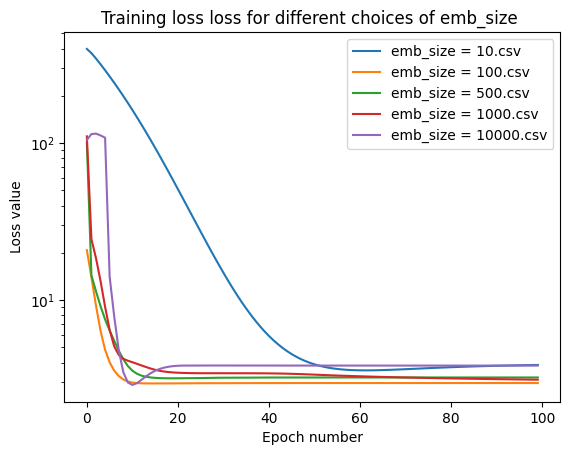

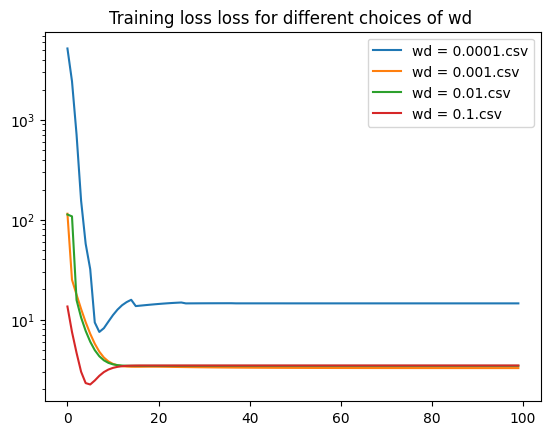

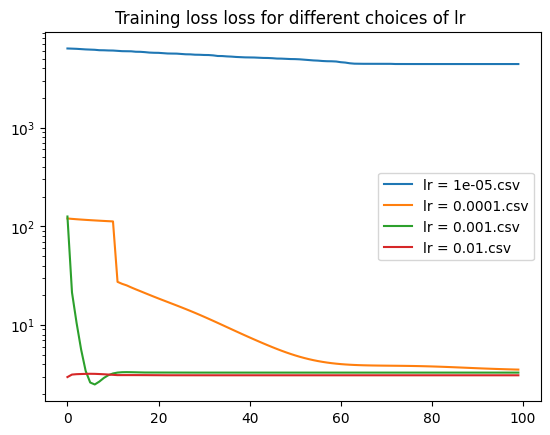

In [33]:
import functools


def compare_hyperparameter_results(data: Iterable[str]):
    plt_calls = {}
    for results_fn in data:
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        res = pd.read_csv(results_fn, header=None)
        setting = results_fn[results_fn.find("_") + 1 :]
        variable = setting.split("=")[0]
        if variable in plt_calls:
            plt_calls[variable].append(
                functools.partial(plt.plot, res[1], label=setting)
            )
        else:
            plt_calls[variable] = [functools.partial(plt.plot, res[0], label=setting)]
    for var, cmd_list in plt_calls.items():
        for cmd in cmd_list:
            cmd()  # plt.plot(...) for specific variable
        plt.legend()
        plt.yscale("log")
        plt.title(f"Training loss loss for different choices of {var}")
        plt.savefig(f"hyperparams_train_{var}.pdf")
        plt.show()


files_20epochs = [
    "results/2022.10.24.11.33/losses_emb_size = 10.csv",
    "results/2022.10.24.11.34/losses_emb_size = 100.csv",
    "results/2022.10.24.11.39/losses_emb_size = 500.csv",
    "results/2022.10.24.11.47/losses_emb_size = 1000.csv",
    "results/2022.10.24.13.29/losses_wd = 0.0001.csv",
    "results/2022.10.24.13.33/losses_wd = 0.001.csv",
    "results/2022.10.24.13.37/losses_wd = 0.01.csv",
    "results/2022.10.24.13.50/losses_lr = 0.001.csv",
    "results/2022.10.24.13.56/losses_lr = 0.01.csv",
]
files = [
    "results/2022.10.30.21.21/losses_emb_size = 10.csv",
    "results/2022.10.30.21.23/losses_emb_size = 100.csv",
    "results/2022.10.30.21.24/losses_emb_size = 500.csv",
    "results/2022.10.30.21.26/losses_emb_size = 1000.csv",
    "results/2022.10.30.21.32/losses_emb_size = 10000.csv",
    "results/2022.10.30.21.33/losses_wd = 0.0001.csv",
    "results/2022.10.30.21.34/losses_wd = 0.001.csv",
    "results/2022.10.30.21.36/losses_wd = 0.01.csv",
    "results/2022.10.30.21.37/losses_wd = 0.1.csv",
    "results/2022.10.30.21.39/losses_lr = 1e-05.csv",
    "results/2022.10.30.21.40/losses_lr = 0.0001.csv",
    "results/2022.10.30.21.42/losses_lr = 0.001.csv",
    "results/2022.10.30.21.43/losses_lr = 0.01.csv",
]
compare_hyperparameter_results(files)

### Adding neural layers to CF model

In [ ]:
class HM_neural(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        


""" 
class HM_model(torch.nn.Module):
    def __init__(self, num_customer, num_articles, embedding_size):
        super(HM_model, self).__init__()
        self.customer_embed = torch.nn.Embedding(
            num_embeddings=num_customer, embedding_dim=embedding_size
        )
        self.art_embed = torch.nn.Embedding(
            num_embeddings=num_articles, embedding_dim=embedding_size
        )
        self.customer_bias = torch.nn.Embedding(num_customer, 1)
        self.article_bias = torch.nn.Embedding(num_articles, 1)

    def forward(self, customer_row, article_row):
        customer_embed = self.customer_embed(customer_row)
        art_embed = self.art_embed(article_row)
        # dot_prod_old = torch.sum(torch.mul(customer_embed, art_embed), 1)
        dot_prod = (customer_embed * art_embed).sum(dim=1, keepdim=True)
        # Add bias nodes to model:
        dot_prod = (
            dot_prod + self.customer_bias(customer_row) + self.article_bias(article_row)
        )
        return torch.sigmoid(dot_prod)

"""

In [ ]:
dataset = read_dataset_obj("object_storage/HM_data.pckl")
dataset.df_id.head()

,customer_id,article_id,label
0,58,1566,0
1,1174,563,0
2,1107,1256,0
3,1017,310,0
4,1948,1472,0


In [ ]:
dataset.df_id.describe().loc[["count", "min", "max"]]

In [ ]:
dataset.train.dataset.df_id.iloc[dataset.train.indices]

,customer_id,article_id,label
468,231,821,0
746,1062,953,0
977,1251,991,0
449,970,152,0
1626,1242,1122,0
...,...,...,...
1347,1772,1584,0
1845,1625,1583,0
584,187,493,0
1190,583,1850,0
